In [142]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

File ‘airline_passengers.csv’ already there; not retrieving.



In [143]:
!pip install -U statsmodels

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import itertools

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [145]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [146]:
df.index.freq = 'MS'

In [147]:
df.shape

(144, 1)

In [148]:
# Assume the forecast horizon we care about is 12
# Validate over 10 steps
h = 12
steps = 10
Ntest = len(df) - h - steps + 1

In [149]:
# Configuration hyperparameters to try
trend_type_list = ['add', 'mul']
seasonal_type_list = ['add', 'mul']
damped_trend_list = [True, False]
init_method_list = ['estimated', 'heuristic', 'legacy-heuristic']
use_boxcox_list = [True, False, 0] # 0 corresponds to log. As stated in cell below, string 'log' gives error, so we indirectly access log by
# passing 0. Remember box cox transformation: (x^lambda - 1)/lambda . When lambda tends to zero, this takes 0/0 form. So, we apply
# L'HOSPITAL rule for taking limit: lim(lambda->0) (x^lambda - 1)/lambda = lim(lambda->0) (x^lambda * ln x) [By L'HOSPITAL rule]= ln x

In [150]:
# NOTE: statsmodels documentation states that 'log' is an acceptable input
#       for use_boxcox. This is false.

In [151]:
def walkforward(
    trend_type,
    seasonal_type,
    damped_trend,
    init_method,
    use_boxcox,
    debug=False):

  # store errors
  errors = []
  seen_last = False
  steps_completed = 0

  for end_of_train in range(Ntest, len(df) - h + 1):
    # We don't have to manually "add" the data to our dataset
    # Just index it at the right points - this is a "view" not a "copy"
    # So it doesn't take up any extra space or computation
    train = df.iloc[:end_of_train] # In this implementation train window size is constantly increasing whereas test window size remains fixed
    test = df.iloc[end_of_train:end_of_train + h]

    if test.index[-1] == df.index[-1]:
      seen_last = True

    steps_completed += 1

    hw = ExponentialSmoothing(
        train['Passengers'],
        initialization_method=init_method,
        trend=trend_type,
        damped_trend=damped_trend,
        seasonal=seasonal_type,
        seasonal_periods=12,
        use_boxcox=use_boxcox)
    res_hw = hw.fit()

    # compute error for the forecast horizon
    fcast = res_hw.forecast(h)
    error = mean_squared_error(test['Passengers'], fcast)
    errors.append(error)

  if debug:
    print("seen_last:", seen_last)
    print("steps completed:", steps_completed)

  return np.mean(errors)

In [152]:
# test our our function
walkforward('add', 'add', False, 'legacy-heuristic', 0, debug=True)

seen_last: True
steps completed: 10


np.float64(1448.227487951414)

In [153]:
# Iterate through all possible options (i.e. grid search)
tuple_of_option_lists = (
    trend_type_list,
    seasonal_type_list,
    damped_trend_list,
    init_method_list,
    use_boxcox_list,
)
for x in itertools.product(*tuple_of_option_lists):
  print(x)

('add', 'add', True, 'estimated', True)
('add', 'add', True, 'estimated', False)
('add', 'add', True, 'estimated', 0)
('add', 'add', True, 'heuristic', True)
('add', 'add', True, 'heuristic', False)
('add', 'add', True, 'heuristic', 0)
('add', 'add', True, 'legacy-heuristic', True)
('add', 'add', True, 'legacy-heuristic', False)
('add', 'add', True, 'legacy-heuristic', 0)
('add', 'add', False, 'estimated', True)
('add', 'add', False, 'estimated', False)
('add', 'add', False, 'estimated', 0)
('add', 'add', False, 'heuristic', True)
('add', 'add', False, 'heuristic', False)
('add', 'add', False, 'heuristic', 0)
('add', 'add', False, 'legacy-heuristic', True)
('add', 'add', False, 'legacy-heuristic', False)
('add', 'add', False, 'legacy-heuristic', 0)
('add', 'mul', True, 'estimated', True)
('add', 'mul', True, 'estimated', False)
('add', 'mul', True, 'estimated', 0)
('add', 'mul', True, 'heuristic', True)
('add', 'mul', True, 'heuristic', False)
('add', 'mul', True, 'heuristic', 0)
('add

In [154]:
best_score = float('inf')
best_options = None
for x in itertools.product(*tuple_of_option_lists):
  score = walkforward(*x)

  if score < best_score:
    print("Best score so far:", score)
    best_score = score
    best_options = x

Best score so far: 412.70439433481533
Best score so far: 397.51642337228634
Best score so far: 368.8467123043263
Best score so far: 320.68497356823144
Best score so far: 307.9434782402395
Best score so far: 300.95995233097807
Best score so far: 255.99878409662014
Best score so far: 249.58266478996705


In [155]:
print("best score:", best_score)

best_trend_type, best_seasonal_type, best_damped_trend, best_init_method, best_use_boxcox = best_options
print("trend_type", best_trend_type)
print("seasonal_type", best_seasonal_type)
print("damped_trend", best_damped_trend)
print("init_method", best_init_method)
print("use_boxcox", best_use_boxcox)

best score: 249.58266478996705
trend_type mul
seasonal_type add
damped_trend False
init_method legacy-heuristic
use_boxcox False


In [156]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [157]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method=best_init_method,
    trend=best_trend_type,
    damped_trend=best_damped_trend,
    seasonal=best_seasonal_type,
    seasonal_periods=12,
    use_boxcox=best_use_boxcox)
res_hw = hw.fit()

In [158]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [159]:
df.loc[train_idx, 'TrainPred'] = res_hw.fittedvalues
df.loc[test_idx, 'Forecast'] = res_hw.forecast(Ntest)

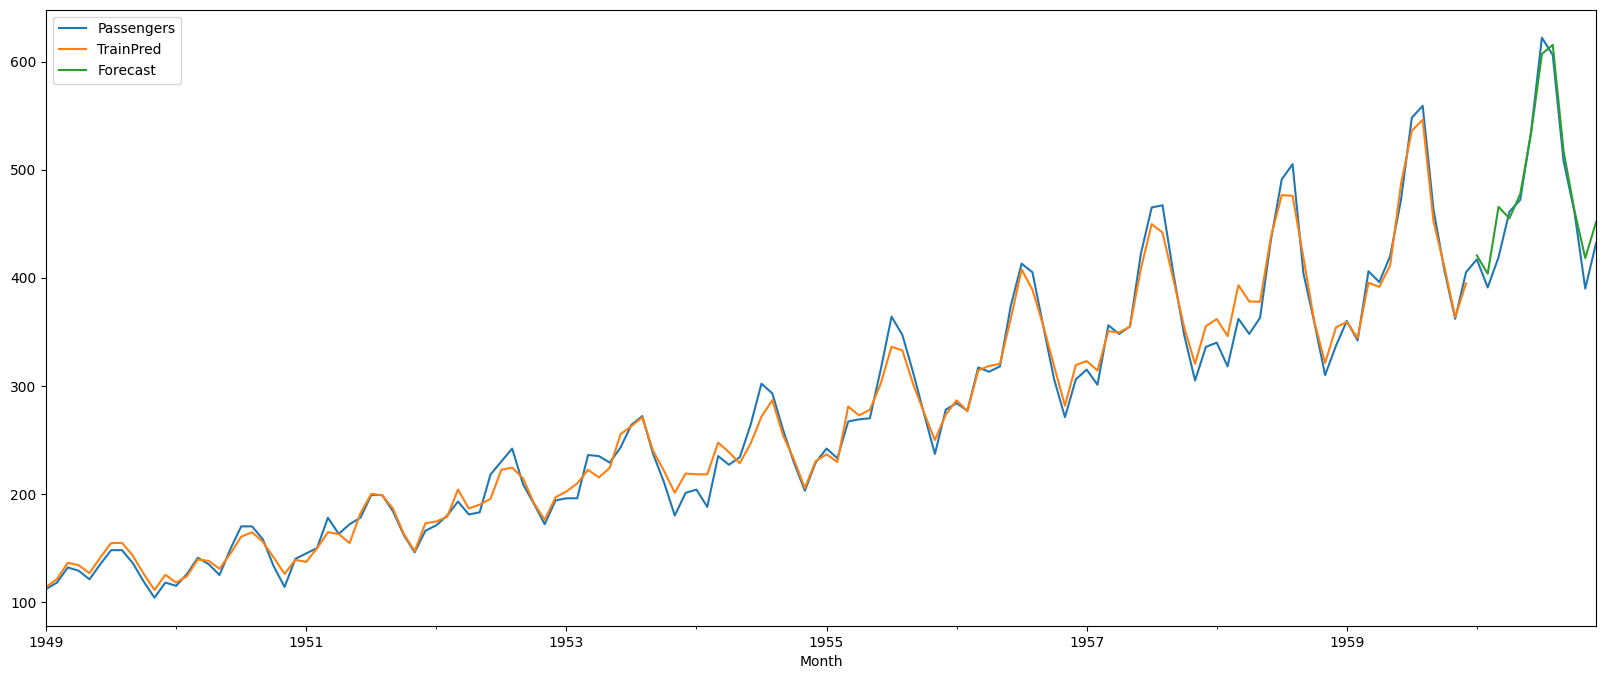

In [160]:
df[['Passengers', 'TrainPred', 'Forecast']].plot(figsize=(20, 8));